In [1]:
import numpy as np
import scipy as sp
import scipy.integrate as integrate
import matplotlib.pyplot as plt 
import astropy.units as u
import astropy.constants as const

# Exercise 3 -- calculate [OIII] 4363/5007 A ratios as function of T and n

In [2]:
# some given data from the question

# collision strengths
Omega_G3 = 2.17 # Ω (3P, 1D) 
Omega_34 = 0.62 # Ω (1D, 1S) 
Omega_G4 = 1.18 # Ω (3P, 1S) 

# QM degeneracies
g_G = 9 
g_3 = 5
g_4 = 1

In [3]:
# some atomic data first: 
# [OIII] 4363 Angstrom Auroral line.  
lam43 =  4363.209 * u.AA
A43   =  1.71e+00 * u.s**-1 
E43   =  -(20273.27-43185.7) * u.cm**-1 * const.h * const.c

# [OIII] 2321 Angstrom UV1 line.  
lam41 =  2320.951 * u.AA
A41   =  2.15e-01 * u.s**-1 
E41   =  -(113.178-43185.74) * u.cm**-1 * const.h * const.c

# two [OIII] strong lines at 4959 and 5007 Angstrom.  
lam32 =  4958.911 * u.AA
A32   =  6.21e-03  * u.s**-1 
E32   =  -(113.178-20273.27) * u.cm**-1 * const.h * const.c

lam31 =  5006.843 * u.AA
A31   =  1.81e-02  * u.s**-1 
E31   =  -(306.174-20273.27) * u.cm**-1 * const.h * const.c

E3G   = (E32+E31)/2  # average the energy for the first transition
A3G   = 1/ (1/A32 + 1/A31)    # but sum the A rates 

In [4]:
# need a function for collission strength. 
def get_a_Clu(Omega_lu, g_l, T_e, n_e, Eul): 
    T4     = T_e / 1e4 / u.K
    prefac = 8.629e-8 * u.cm**3 / u.second
    expval = np.exp(-Eul / const.k_B / T_e)
    C = prefac * T4**-0.5 * Omega_lu / g_l * expval * n_e
    return C

get_a_Clu(Omega_G3, g_G, 1e4*u.K, 1e4*u.cm**-3 , E3G)

<Quantity 1.16010764e-05 1 / s>

## Start by just looking at equation 18.4 which should give the flux ratio of the auroral (4363A) / strong (5007A) line fluxes
appropriate in the low density limit, where every collisional excitation results in the emission of a photon

begin by coding up eq 18.4, which is 
$\frac{j(4\rightarrow3)}{j(3\rightarrow2)} = \frac{A_{43}E_{43}}{A_{32}E_{32}} \frac{(A_{32}+A_{31})\Omega_{04}\exp(-E_{43}/kT)}{(A_{43}+A_{41})\Omega_{03} + A_{43}\Omega_{04}\exp(-E_{43}/kT)}$

Text(0, 0.5, 'Flux ratio of [OIII] 5007/4363 Angstrom ')

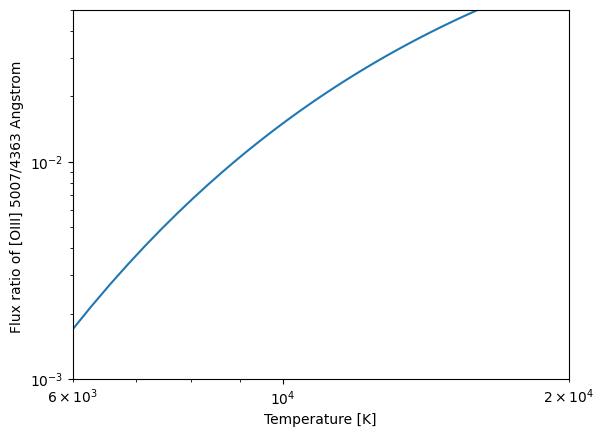

In [5]:
Tvec = np.linspace(1000, 30000,100) * u.K

top     = A43 * E43 * A3G * Omega_G4 * np.exp(-E43 / const.k_B / Tvec)
bottom  = A32 * E31 * ( (A43+A41) * Omega_G3 +  A43 * Omega_G4 * np.exp(-E43 / const.k_B / Tvec) )
linerat = top / bottom

plt.figure()
plt.plot(Tvec, linerat)
plt.loglog()
plt.axis([6000,20000,1e-3,5e-2]) 
plt.xlabel('Temperature [K]')
plt.ylabel('Flux ratio of [OIII] 5007/4363 Angstrom ')

## Characteristics of the above plot
* All excited levels are populated by collisions with electrons.  
* The n=4 level is ~5eV above the ground state, while the n=3 level is ~2.5 eV above the ground state. 
* the 4363 A line comes from radiative decay in n=4->3, while the 5007 A line comes from 3->ground
* Electron temperatures are drawn from the Maxwell-Boltzmann distribution, which behaves as an exponential at high energies.  Thus there are many fewer 5eV electrons than 2.5eV electrons.
* This ratio increases with temperautre, and the ratio of n=4/n=3 level populations increases with T. 
* Thus the 4363/5007 A line ratio increases with temperature.

<B> this is how we measure gas temperatures in the ISM </B>

However this ratio is only accurate if every exitation results in emission of a photon, which happens only in the low density limit where collisional deexcitation is not important.



## Now add collissional deexcitation
### start with level populations at equilibrium
The rationale is exactly the same as in Chapter 18 of Draine and the equations we used above, but we need to modify the 'top' and 'bottom' variables to include also collisional deexcitation. 

Equilibrium when incoming (left) and outgoing (right) levels are equal

Collisional terms are listed before radiative ones.  Upwards are listed before downwards. 

**Level 4**:  $ n_G C_{G4} + n_3 C_{34} 
              = n_4 ( C_{43} + C_{4G} + A_{43} + A_{4G})$
              
Where $A_{4G} = A_{40} + A_{41} + A_{42}$

**Level 3**:  $ n_G C_{G3} + n_4 ( C_{43} + A_{43} )
              = n_3 ( C_{34} + C_{3G} + A_{3G} )$
              
Where $A_{3G} = A_{30} + A_{31} + A_{32}$

**Level G**:  $ n_3 ( C_{3G} + A_{3G}) + n_4 ( C_{4G} + A_{4G})
              = n_G ( C_{G3} + C_{G4} )$

We also insist that there is a fixed number of atoms, such that:

$n = n_G + n_3 + n_4$

From this we can use the Level 4 and Level 3 population equations to write down an equation for the level we do not explicitly need: $n_G$.  From Level 4:

$ n_G = \frac{n_4 ( C_{43} + C_{4G} + A_{43} + A_{4G}) -n_3 C_{34}}{C_{G4}} $

And from Level 3:
 
$ n_G  = \frac{n_3 ( C_{34} + C_{3G} + A_{3G} ) - n_4 ( C_{43} + A_{43} )}{C_{G3}}$

Equating the above: 

$n_3 ( C_{34} + C_{3G} + A_{3G} ) C_{G4} - n_4 ( C_{43} + A_{43} ) C_{G4} = 
 n_4 ( C_{43} + C_{4G} + A_{43} + A_{4G}) C_{G3} -n_3 C_{34} C_{G3}
$

Collecting $n_3$ and $n_4$ terms

$n_3 ( C_{34} + C_{3G} + A_{3G} ) C_{G4} + n_3 C_{34} C_{G3}
   = 
 n_4 ( C_{43} + C_{4G} + A_{43} + A_{4G}) C_{G3} + n_4 ( C_{43} + A_{43} ) C_{G4} $

$n_3 ( C_{34}C_{G4} + C_{3G}C_{G4} + A_{3G}C_{G4} + C_{34}C_{G3} ) 
=n_4 ( C_{43}C_{G3} + C_{4G}C_{G3} + A_{43}C_{G3} + A_{4G}C_{G3} + C_{43}C_{G4} + A_{43}C_{G4} )  $

And sort for $n_4/n_3$

$\frac{n_4}{n_3} = \frac{C_{34}C_{G4} + C_{3G}C_{G4} + A_{3G}C_{G4} + C_{34}C_{G3}}{C_{43}C_{G3} + C_{4G}C_{G3} + A_{43}C_{G3} + A_{4G}C_{G3} + C_{43}C_{G4} + A_{43}C_{G4}}$




Text(0, 0.5, 'Flux ratio of [OIII] 4363/5007 Angstrom ')

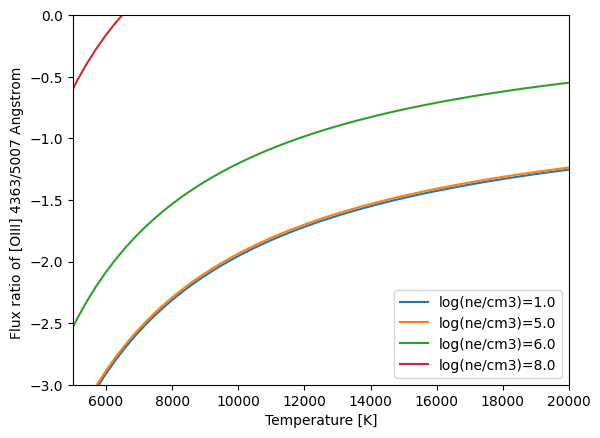

In [6]:
# Write the above in code 
E4G = E41 # approximate the energies of all transitions to ground by a single transtion (good to ~1%)
A4G = A41

def lrat_from_Tn(temp, n_e): 
    C34 = get_a_Clu(Omega_34, g_3, Tvec, n_e, E43)
    CG4 = get_a_Clu(Omega_G4, g_G, Tvec, n_e, E41)
    CG3 = get_a_Clu(Omega_G3, g_3, Tvec, n_e, E3G)
    C3G = get_a_Clu(Omega_G3, g_G, Tvec, n_e, E3G)
    C4G = get_a_Clu(Omega_G4, g_G, Tvec, n_e, E4G)
    C43 = get_a_Clu(Omega_34, g_4, Tvec, n_e, E43)
    
    num = C34*CG4 + C3G*CG4 + A3G*CG4 + C34*C3G 
    den = C43*CG3 + C4G*CG3 + A43*CG3 + A4G*CG3 + C43*CG4 + A43*CG4
    
    n4_n3   = num/den 
    fluxrat = n4_n3 * (E43/E3G) * (A43 / A3G)
    return fluxrat

lab = 'log(ne/cm3)={:1.1f}'
plt.figure()
plt.plot(Tvec, np.log10(lrat_from_Tn (Tvec, 1e1*u.cm**-3)), label=lab.format(1))
plt.plot(Tvec, np.log10(lrat_from_Tn (Tvec, 1e4*u.cm**-3)), label=lab.format(5))
plt.plot(Tvec, np.log10(lrat_from_Tn (Tvec, 1e6*u.cm**-3)), label=lab.format(6))
plt.plot(Tvec, np.log10(lrat_from_Tn (Tvec, 1e8*u.cm**-3)), label=lab.format(8))
plt.axis([5000,20000, -3,0])
plt.legend()
plt.xlabel('Temperature [K]')
plt.ylabel('Flux ratio of [OIII] 4363/5007 Angstrom ')
#

## Characteristics of the above plot
The shape of the curves is explained above. 

* The critical density of [OIII] 5007 is ~6x10$^5$ cm$^{-3}$, so very close to a million particles per cc. 
* Above this density, collisional deexcitation from the n=3 level dominates over radiative deexcitation. 
* Thus, the 5007 AA line is suppressed, and the 4363/5007 AA line ratio is boosted. 
* The effect of collisions is barely visible between 10 and 100,000 cm$^{-3}$, but at a million/cc the ratio is much higher.

## Part B

This is the same as problem 2, except we need to add collisinal cooling from the O++ ion. 
In the low density limit this is the same as the cells above, and we do not have to worry about collisional deexcitation. 
Why?  Collisional deexcitation does not result in the emission of a photon, so the nebula does not cool. 

In [7]:
# need to introduce Gamma_CE_OIII to problem 2
# this is the sum of P43 + P4G + P3G
# Each of these depends upon n_OIII, n_e, and T

def get_Lambda_CE_OIII_from_Temp_2N(temp, nume, numO):   
    
    CG4 = get_a_Clu(Omega_G4, g_G, temp, nume, E41)
    CG3 = get_a_Clu(Omega_G3, g_3, Tvec, nume, E3G)
    
    P43 = E43 * numO * CG4 * A43 / (A43+A41)
    P3G = E3G * numO * (CG3 + CG4 * A43 / (A43+A41)) * A32 / (A32+A31)
    P4G = E4G * numO * CG4 * A41 / (A43+A41)
    return P43 + P3G + P4G 


In [8]:
# Model parameters
T_star   = 4.e4     * u.Kelvin
L_star   = 4.e39    * u.erg/u.second
n_H      = 1.e4     * u.cm**-3
T_gas    = 10000.   * u.Kelvin
alpha_B  = 2.59e-13 * u.cm**3 / u.second
sigma_H0 = 6.3e-18  * u.cm**2
E_Lya    = 10.2     * u.eV
A_Lya    = 6.265e8  * u.s**-1

Tvec = np.logspace(1,5,1000) * u.K  # logarithmically spaced vector of T from 1000 to 100,000 K


In [9]:
Lambda_CE_OIII = \
    get_Lambda_CE_OIII_from_Temp_2N(Tvec, 1e4*u.cm**-3, 1*u.cm**-3)

Text(0, 0.5, 'Cooling rate from [OIII] 5007 (erg/s/cm3$^3$)')

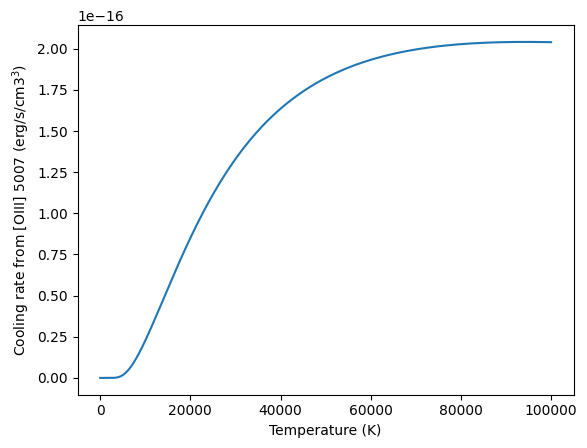

In [10]:
plt.figure()
plt.plot(Tvec, Lambda_CE_OIII.cgs)
plt.xlabel('Temperature (K)')
plt.ylabel(r'Cooling rate from [OIII] 5007 (erg/s/cm3$^3$)')

In [11]:
# introduce cooling and heating functions.  all direct copies from workbook 2
psi = 1.5
g2 = 8
g1 = 4
Omega_21 = 0.45 # Osterbrock table 3.12.  Weakly temperature dependent.  take average value 

def alpha_B_from_T(temp): 
    abT = alpha_B * (temp/1e4/u.K)**(-0.833-0.035*np.log(temp/1e4/u.K))
    return abT

def err_B_from_T(temp): 
    errT = (0.684 - 0.0416 * np.log(temp/1e4/u.K)) * const.k_B * temp
    return errT

def get_Gamma_PE_from_Temp_Nion(temp, nion): 
    gPE = alpha_B_from_T(temp) * nion**2 * psi * const.k_B * T_star
    return gPE

def get_Lambda_RR_from_Temp_Nion(temp, nion): 
    lRR = alpha_B_from_T(temp) * nion**2 * err_B_from_T(temp)
    return lRR 

def get_Lambda_FF_from_Temp_Nion(temp, nion): 
    lFF = 1.422e-25*u.cm**3*u.erg/u.second * \
         (1 + 0.44 / (1 + 0.058 * np.log(temp/10**5.4/u.K)**2 ) ) * (temp/1e4/u.K)**0.5 * nion**2
    return lFF

def kul_from_T(temp, Omega_ul, g_u): 
    kul = const.h**2 / (2 * np.pi * const.m_e)**(3/2) / (const.k_B * temp)**(1/2) * Omega_ul / g_u 
    return kul 

def n_H0_2_from_nH0_ne_T(numH0, nume, temp): 
    k21   = kul_from_T(temp, Omega_21, g2 )
    expon = np.exp(-E_Lya / const.k_B / temp)
    num   = (g2/g1) * numH0 * k21* expon
    den   =  k21 + A_Lya/nume + (g2/g1)*k21*expon
    return num/den

def get_Lambda_CE_from_Temp_2N(temp, nume, numn):   #numn = numneutral 
    n2 = n_H0_2_from_nH0_ne_T(numn, nume, temp)# * A_Lya * E_Lya
    lCE = n2 * A_Lya * E_Lya
    return lCE

Text(0, 0.5, 'Cooling rate from [OIII] 5007 (erg/s/cm3$^3$)')

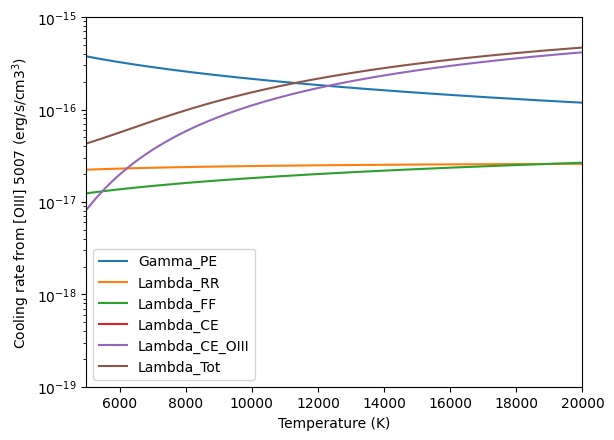

In [12]:
# set the oxygen abundance (O/H) to be the solar value.  12+log (O/H) = 8.69 (Asplund et al 2009)
OoverH = 10.**(8.69-12)

Gamma_PE       = get_Gamma_PE_from_Temp_Nion(Tvec, n_H)
Lambda_RR      = get_Lambda_RR_from_Temp_Nion(Tvec, n_H)
Lambda_FF      = get_Lambda_FF_from_Temp_Nion(Tvec, n_H)
Lambda_CE      = get_Lambda_CE_from_Temp_2N(Tvec, n_H, 1e-3*u.cm**-3)
Lambda_CE_OIII = get_Lambda_CE_OIII_from_Temp_2N(Tvec, n_H, 1*OoverH*n_H)

Lambda_Tot = Lambda_RR+Lambda_FF+Lambda_CE+Lambda_CE_OIII

plt.figure()
plt.plot(Tvec, Gamma_PE.cgs.value  , label='Gamma_PE' )
plt.plot(Tvec, Lambda_RR.cgs.value , label='Lambda_RR' )
plt.plot(Tvec, Lambda_FF.cgs.value , label='Lambda_FF' )
plt.plot(Tvec, Lambda_CE.cgs.value , label='Lambda_CE' )
plt.plot(Tvec, Lambda_CE_OIII.cgs.value , label='Lambda_CE_OIII' )
plt.plot(Tvec, Lambda_Tot.cgs.value, label='Lambda_Tot' )
plt.legend()
plt.semilogy()
plt.xlim([5000,20000])
plt.ylim([1.e-19,1e-15])
plt.xlabel('Temperature (K)')
plt.ylabel(r'Cooling rate from [OIII] 5007 (erg/s/cm3$^3$)')

# and now the collisional OIII cooling dominates

## Characteristics of the above plot
The plot is the same as in workbook 2, but the collisional cooling by [OIII] has been added.
* Note that [OIII] cooling doimiantes above 14,000 K for this gas density and abundance. 

11305.950460369768


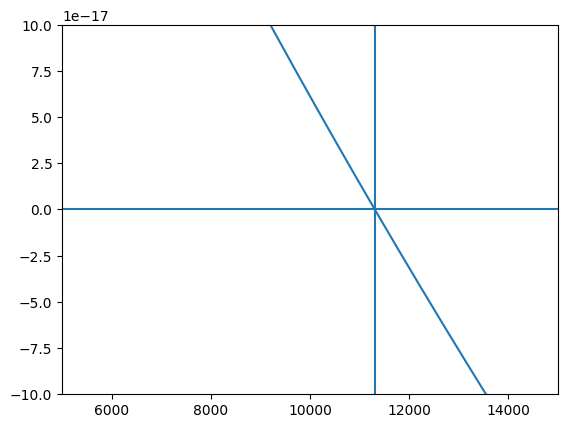

In [13]:
# get a new function for the total heating - cooling rate
def get_Heat_minus_Cool( nelectron, nneutral, temperature  ): 

    heat_PE  = get_Gamma_PE_from_Temp_Nion (temperature*u.K, nelectron*u.cm**-3).cgs.value
    cool_RR  = get_Lambda_RR_from_Temp_Nion(temperature*u.K, nelectron*u.cm**-3).cgs.value
    cool_FF  = get_Lambda_FF_from_Temp_Nion(temperature*u.K, nelectron*u.cm**-3).cgs.value
    cool_CE  = get_Lambda_CE_from_Temp_2N  (temperature*u.K, nelectron*u.cm**-3, nneutral*u.cm**-3).cgs.value
    cool_CE_OIII = \
           get_Lambda_CE_OIII_from_Temp_2N (temperature*u.K, nelectron*u.cm**-3, OoverH*nelectron*u.cm**-3).cgs.value
    cool_Tot = cool_RR+cool_FF+cool_CE+cool_CE_OIII
    diff     = heat_PE - cool_Tot
    
    return diff

from scipy.stats import linregress


d = get_Heat_minus_Cool( 1e4,  1e-1, Tvec.value )

if d.min() * d.max() >=0: 
    tb = -1. # return a negative number to indicate differnce function cannot cross zero
else: 
    imin = np.absolute(d).argmin()

    tfitvec = Tvec[imin-5:imin+5]
    dfitvec = d   [imin-5:imin+5]
    fit = linregress(dfitvec, tfitvec)
    
    plt.figure()
    plt.plot(Tvec, d)
    plt.axhline(0)
    plt.axvline(fit.intercept)
    plt.axis([5000,15000,-1e-16,1e-16])
    print (fit.intercept)

In [14]:
stardat = np.loadtxt('Q1A_star.txt')
rad = stardat[:,0]
y   = stardat[:,1]
x   = stardat[:,2]
tau = stardat[:,3]

In [15]:
Tneb = np.zeros_like(y)

irad = int(len(y)*0.665)

for irad in range(len(y)-1,0, -1): 
#for irad in [int(len(y)*0.66)]: 
    
    ionfrac  = x[irad]
    nion     =    ionfrac  * n_H.cgs.value
    nneutral = (1-ionfrac) * n_H.cgs.value
    
    if irad%10000==0:
        print (y[irad], ionfrac, nion, nneutral)
        
    d = get_Heat_minus_Cool( nion,  nneutral, Tvec.value )
    if d.min() * d.max() >=0: 
        
        # return a negative number to indicate differnce function cannot cross zero
        Tneb[irad] = -1 
    else: 
        imin = np.absolute(d).argmin()
        
        tfitvec = Tvec[imin-5:imin+5]
        dfitvec = d   [imin-5:imin+5]
        fit = linregress(dfitvec, tfitvec)
        
        Tneb[irad] = fit.intercept
        
        #plt.figure()
        #plt.plot(Tvec, d)
        #plt.axhline(0)
        #plt.axvline(fit.intercept)
        #plt.axis([5000,50000,-1e-16,1e-16])

/home/mhaye/anaconda3/envs/stenv/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


1.15535053 0.0 0.0 10000.0
0.96279211 0.999008955 9990.08955 9.910450000000237
0.770233688 0.999873823 9998.73823 1.2617699999994958
0.577675266 0.999952242 9999.52242 0.4775800000000885
0.385116844 0.999981827 9999.81827 0.18172999999954698
0.192558422 0.999995685 9999.95685 0.04314999999976976


/tmp/ipykernel_190679/24836067.py:2: RuntimeWarning: invalid value encountered in log10
  plt.plot(rad[1:], 10**np.log10(Tneb[1:]))


Text(0, 0.5, 'Temperature [K]')

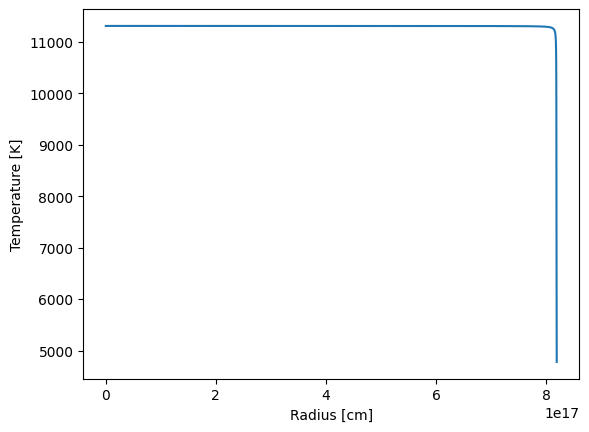

In [16]:
plt.figure()
plt.plot(rad[1:], 10**np.log10(Tneb[1:]))
plt.xlabel('Radius [cm]')
plt.ylabel('Temperature [K]')
#plt.axis([0,1.3,4.05,4.061])
#plt.axvline(1.)

## characteristics of the above plot
Compare to final plot in workbook 2
* outside the Stromgren radius the temperature is still the constant WNM temperature of 5000 K
* inside $R_{S0}$ the temperature has dropped from ~40,000 K to ~12,000.  This is because we have O++ in the nebula, which is a much more efficient coolant.  
* This is done at solar oxygen abundance -- try reducing the abundance by a factor of 10 and see what happens to T